# 1. 定义算法

Sarsa 是一种同策略（on-policy）算法，它优化的是它实际执行的策略，它直接用下一步会执行的动作去优化 Q-table。
其更新公式为：
$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha  [r_{t+1} + \gamma   Q(s_{t+1}, a_{t+1}) - Q(s, a)]
$$
- 同策略在学习的过程中，只存在一种策略，它用一种策略去做动作的选取，也用一种策略去做优化。Sarsa 算法必须执行两次动作得到$(s,a,r,s^\prime,a^\prime)$才可以更新一次；且$a^\prime$是在特定策略$\pi$的指导下执行的动作，因此估计出来的$Q(s_t,a_t)$是在策略$\pi$下的$Q$值，样本生成用的$\pi$和估计的$\pi$是同一个，因此是同策略。
- 该算法由于每次更新值函数时需要知道当前的状态（state）、当前的动作（action）、奖励（reward）、下一步的状态（state）、下一步的动作（action），即$(s,a,r,s^\prime,a^\prime)$这几个值 ，因此得名 Sarsa 算法。
- Sarsa 和 Q-learning 的更新公式是一样的，区别只在目标计算的部分, Sarsa 是$r_{t+1}+\gamma Q(s_{t+1},a_{t+1}) $， Q-learning 是$r_{t+1}+\gamma \max\limits_a Q(s_{t+1},a) $。
- 相比于异策略的 Q-learning ， Sarsa 作为同策略算法需要兼顾探索和利用，训练时相对较为保守，会选择一条相对安全的迭代路线。
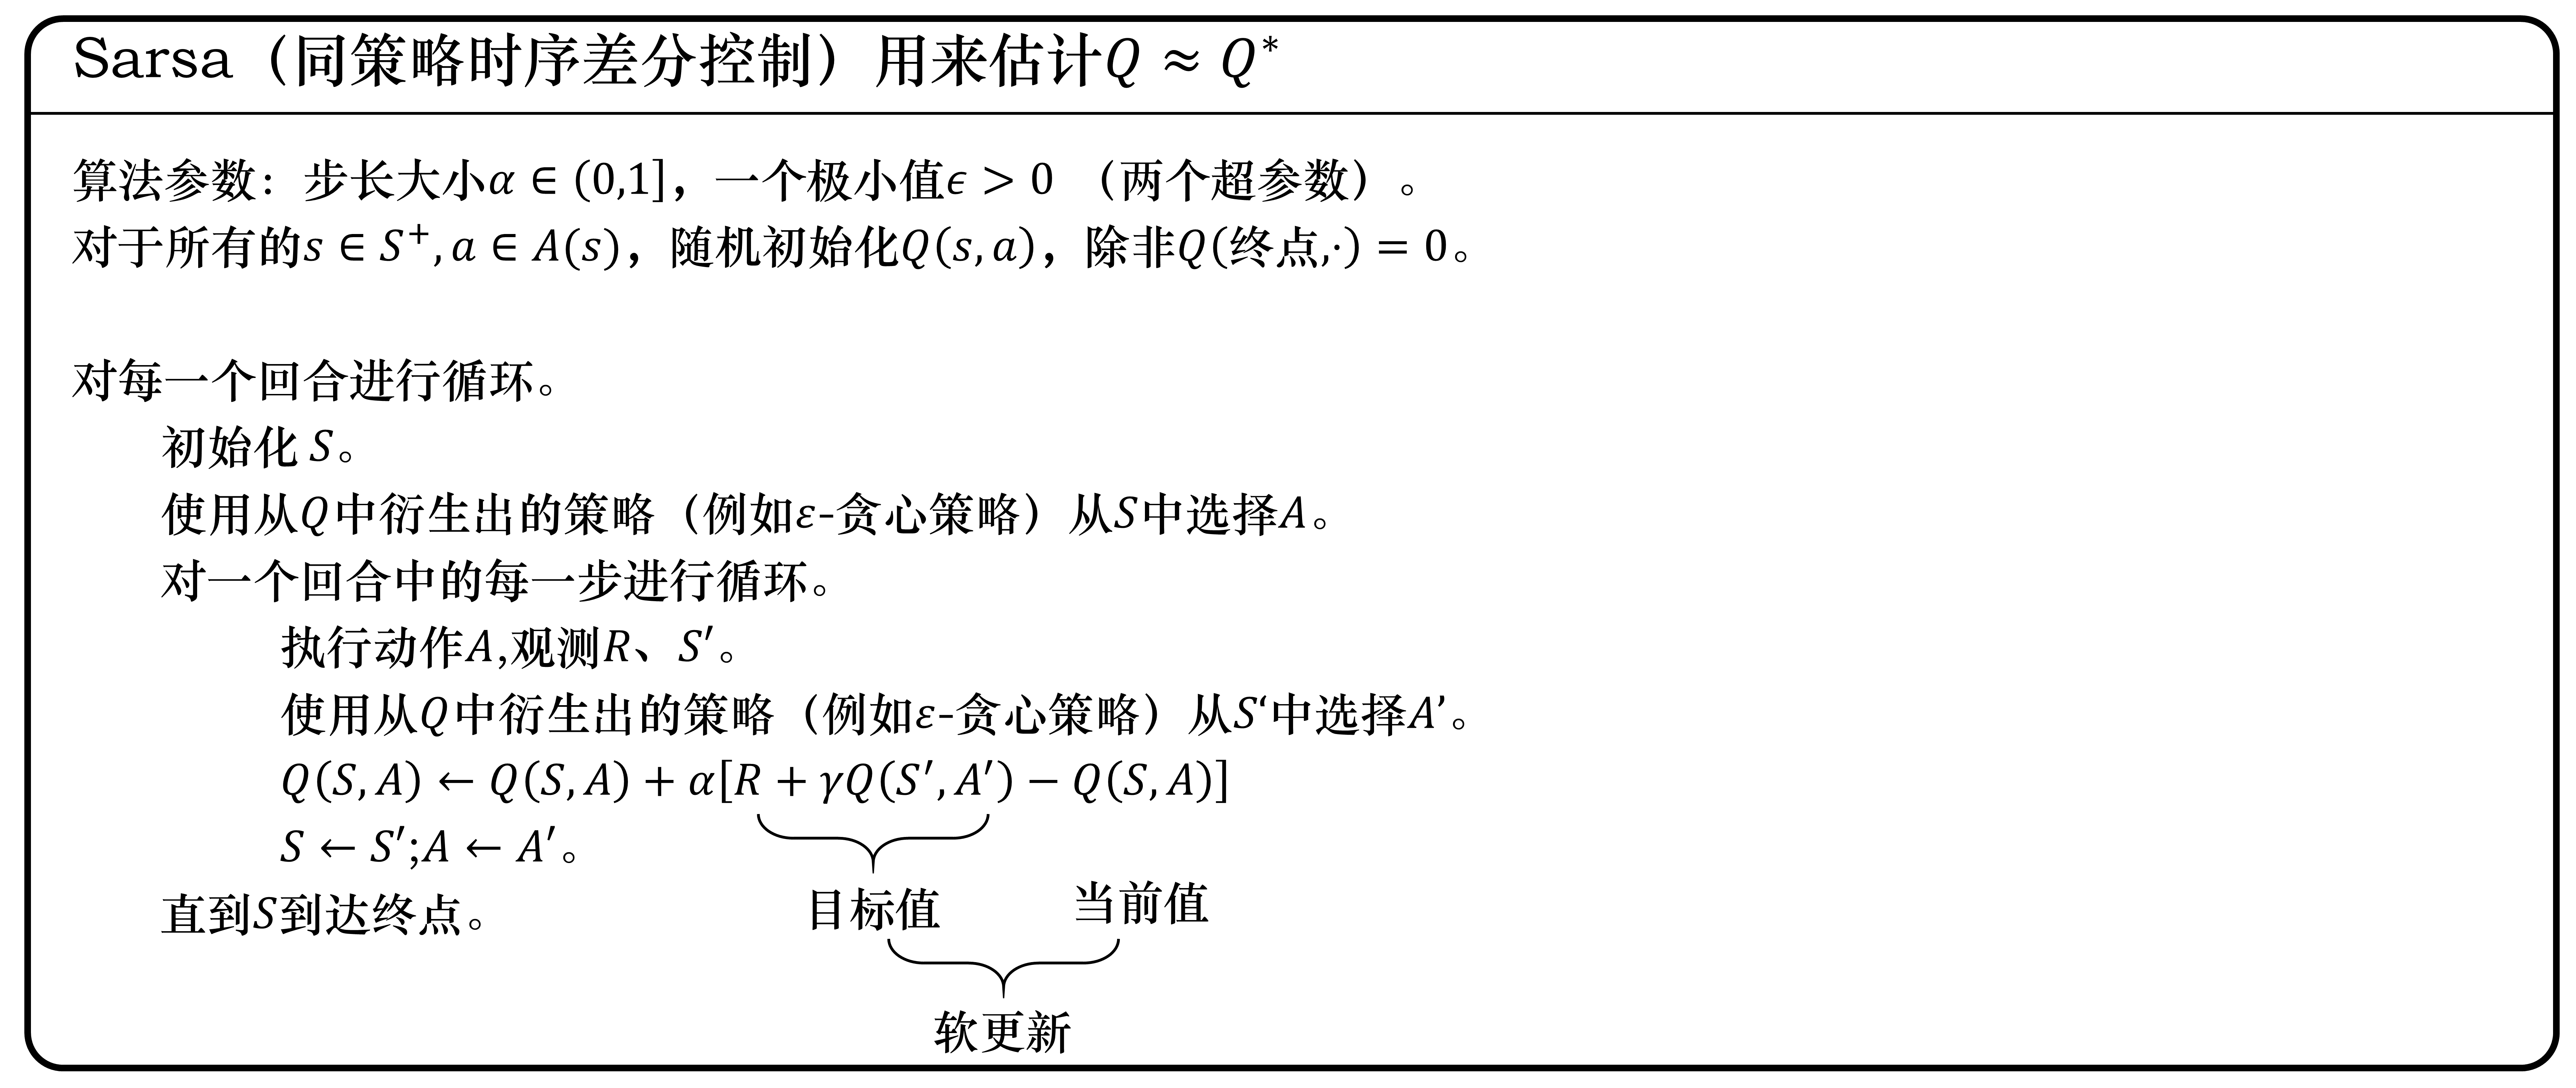

## 1.1 定义模型

In [ ]:
import numpy as np
import math
from collections import defaultdict

class Sarsa(object):
    def __init__(self,cfg):
        '''智能体类
        Args:
            cfg (class): 超参数类
        '''
        self.n_actions = cfg.n_actions 
        self.lr = cfg.lr 
        self.gamma = cfg.gamma    
        self.epsilon = cfg.epsilon_start
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table  = defaultdict(lambda: np.zeros(self.n_actions)) # 使用嵌套字典来表示 Q(s,a)，并将指定所有的 Q_table 创建时， Q(s,a) 初始设置为 0
        self.sample_count = 0  
    def sample_action(self, state):
        ''' 另一种实现 e-greedy 策略的方式
        Args:
            state (array): 状态
        Returns:
            action (int): 动作
        '''
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) # 选择随机动作的概率 epsilon 是对数衰减的
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)]) # 选取与最大 q 值相对应的动作
        else:
            action = np.random.choice(self.n_actions) # 随机选取动作
        return action
    def predict_action(self,state):
        ''' 预测动作
        Args:
            state (array): 状态
        Returns:
            action (int): 动作
        '''
        action = np.argmax(self.Q_table[str(state)])
        return action
    def update(self, state, action, reward, next_state, next_action, done):
        ''' 更新模型
        Args:
            state (array): 当前状态 
            action (int): 当前动作 
            reward (float): 当前奖励信号 
            next_state (array): 下一个状态 
            done (bool): 表示是否达到终止状态 
        '''
        Q_predict = self.Q_table[str(state)][action]
        if done:
            Q_target = reward  # 终止状态 
        else:
            Q_target = reward + self.gamma * self.Q_table[str(next_state)][next_action] # 与 Q-learning 的唯一区别
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict) 

## 1.2 定义模型训练与测试

In [ ]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 一轮的累计奖励 
        ep_step = 0
        state = env.reset(seed = cfg.seed)  # 重置环境并获取初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 采样动作 
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境并返回新状态、奖励、终止状态、截断标志和其他信息
            next_action =  agent.sample_action(next_state)
            agent.update(state, action, reward, next_state, next_action, terminated)  # 更新 agent
            state = next_state  # 更新状态 
            action = next_action # 更新动作
            ep_reward += reward  # 增加奖励 
            if terminated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")
    print("完成训练！")
    return {'rewards':rewards}

def test(cfg, env, agent):
    '''测试
    '''
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    print(cfg.test_eps)
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 一轮的累计奖励 
        ep_step = 0
        state = env.reset(seed = cfg.seed)  # 重置环境并获取初始状态 
        for _ in range(cfg.test_eps):
            if cfg.render:
                env.render()
            ep_step += 1
            action = agent.predict_action(state)  # 预测动作 
            next_state, reward, terminated, truncated , info = env.step(action)   # 更新环境并返回新状态、奖励、终止状态、截断标志和其他信息
            next_action =  agent.sample_action(next_state)
            agent.update(state, action, reward, next_state, next_action, terminated)  # 更新 agent
            state = next_state  # 更新状态 
            action = next_action # 更新动作
            ep_reward += reward  # 增加奖励
            if terminated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}


## 1.3 定义环境

In [ ]:
import gymnasium as gym
import os
import random
import torch

def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.reset(seed=seed) # 环境配置
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # CPU配置
    torch.cuda.manual_seed(seed) # GPU配置
    os.environ['PYTHONHASHSEED'] = str(seed) # python scripts配置
    # cudnn配置
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    all_seed(env,seed=cfg.seed)
    print(env.observation_space.shape)
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    # 更新n_states和n_actions到cfg参数中
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    setattr(cfg, 'action_space', env.action_space) 
    agent = Sarsa(cfg)
    return env,agent

# 2. 设置参数

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self) -> None:
        ## 通用参数
        self.env_name = "CliffWalking-v0" # 环境名称
        self.render = False # 是否渲染环境
        self.algo_name = "Sarsa" # 算法的名称
        self.seed = 1 # 随机种子
        self.device = "cuda" # 用的device 
        self.train_eps = 300 # training的episodes数
        self.test_eps = 10 # testing的episodes数
        self.max_steps = 1000 # 每episode的最大steps数

        ## Sarsa参数
        self.epsilon_start = 0.95 # epsilon 初始值
        self.epsilon_end = 0.01 # epsilon 终止值
        self.epsilon_decay = 300 # epsilon 衰减率
        self.gamma = 0.90 # 奖励折扣因子
        self.lr = 0.1 # 学习率

def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()

# 3. 开始训练

In [ ]:
# 获取参数
cfg = Config() 
env, agent = env_agent_config(cfg)
# 训练
res_dic = train(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}") # 画出结果
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  # 画出结果